In [ ]:
#This script describes the workflow of single-cell QC and clustering of 309,666 cells
#Before running this script, we have already performed doublet prediction and inital clustering analysis, where we identified cells of artefact or doublet-like cells. These results are written as meta information.

#### See Methods of our manuscript for more information.

####  by Haikuo Li @ Humphreys Lab

In [31]:
import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
from matplotlib import rcParams
import matplotlib.font_manager
rcParams['font.sans-serif']=['Arial']
sc.settings.set_figure_params(dpi=100, facecolor='white',fontsize=12)

adata = sc.read('file_name.h5ad')
##read a file in which meta data has been written
##413681 X 48795

scanpy==1.6.1 anndata==0.7.5 umap==0.4.6 numpy==1.19.2 scipy==1.5.2 pandas==1.2.0 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 leidenalg==0.8.3


In [ ]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.3, multi_panel=True,size=0.3)

###the number of genes (per cell) expressed in the count matrix
###the total counts per cell
###the percentage of counts in mitochondrial genes

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt',size=6)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts',size=6)


##QC
adata = adata[adata.obs.n_genes_by_counts < 5000, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

##Next we remove cells of artefact or doublet-like cells, as well as cells with high doublet score (over 0.2).
#### See Methods of our manuscript for more information.
#### After strict QC, we ultimately processed 309666 cells.

adata = adata[:, adata.var.processed_gene_type=='True']
##Protein-coding genes, pseudogenes and genes encoding lincRNAs were maintained in further analysis.

adata = adata[:, adata.var.mt==False]

In [40]:
sc.pp.filter_cells(adata, min_genes=80)
sc.pp.filter_cells(adata, max_counts=5000)

filtered out 14968 cells that have less than 80 genes expressed


Trying to set attribute `.obs` of view, copying.
/home/haikuoli/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


filtered out 9416 cells that have more than 5000 counts


In [ ]:
sc.pp.filter_genes(adata, min_cells=30)

In [42]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata,n_top_genes=5000)

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:03)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


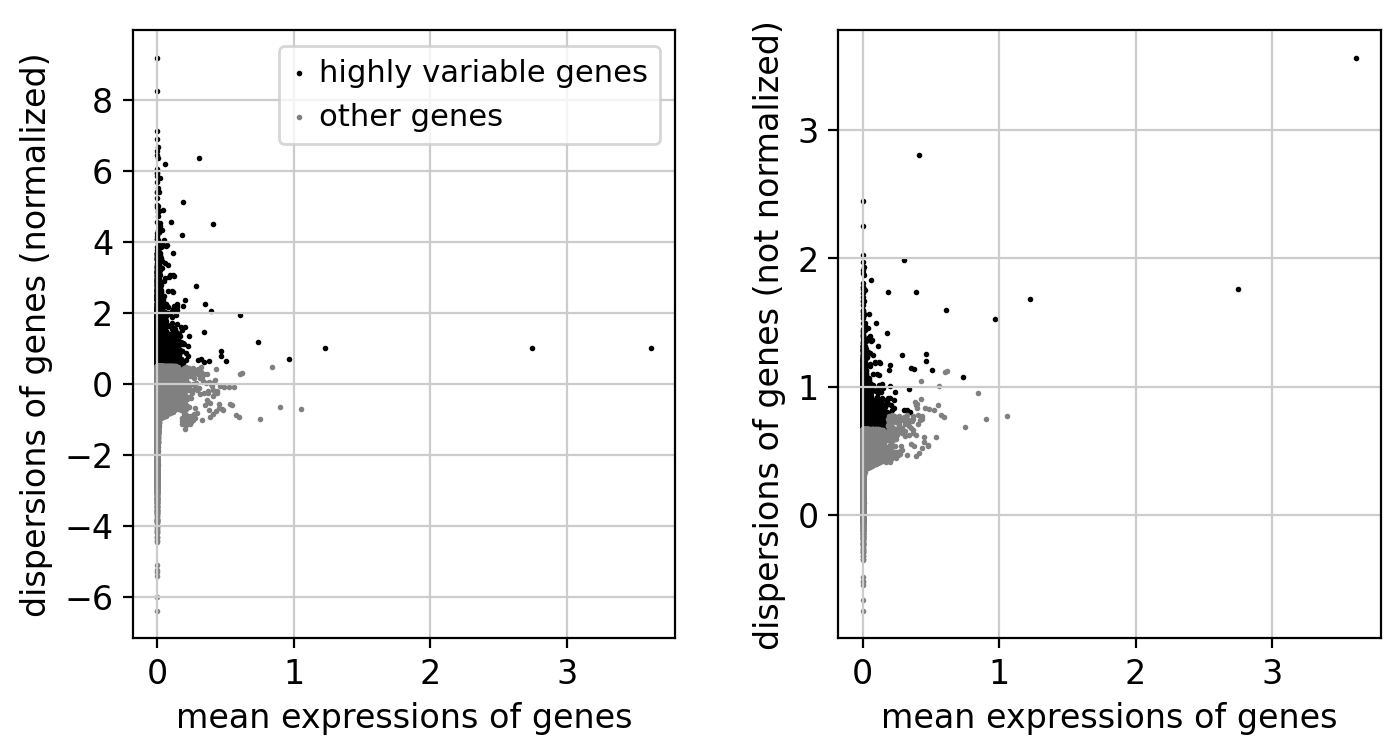

In [45]:
sc.pl.highly_variable_genes(adata)

In [46]:
adata = adata[:, adata.var.highly_variable]

In [48]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    finished (0:21:50)


In [49]:
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack',n_comps=50)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:01:32)


In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

In [78]:
sc.tl.pca(adata, svd_solver='arpack',n_comps=40)
sc.pp.neighbors(adata, n_neighbors=40,metric='cosine')

computing PCA
    on highly variable genes
    with n_comps=40


/home/haikuoli/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


    finished (0:01:23)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:12:34)


In [ ]:
sc.tl.umap(adata,min_dist=0.01,spread=2,maxiter=3000)

from matplotlib import rcParams
rcParams['figure.figsize'] = 10,10

sc.pl.umap(adata, color='celltype_0404',title="",size=0.5,legend_loc='on data')

computing UMAP


In [ ]:
sc.tl.leiden(adata,key_added='leiden')
##run leiden clustering

#sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon',key_added='rank_genes_groups_leiden')

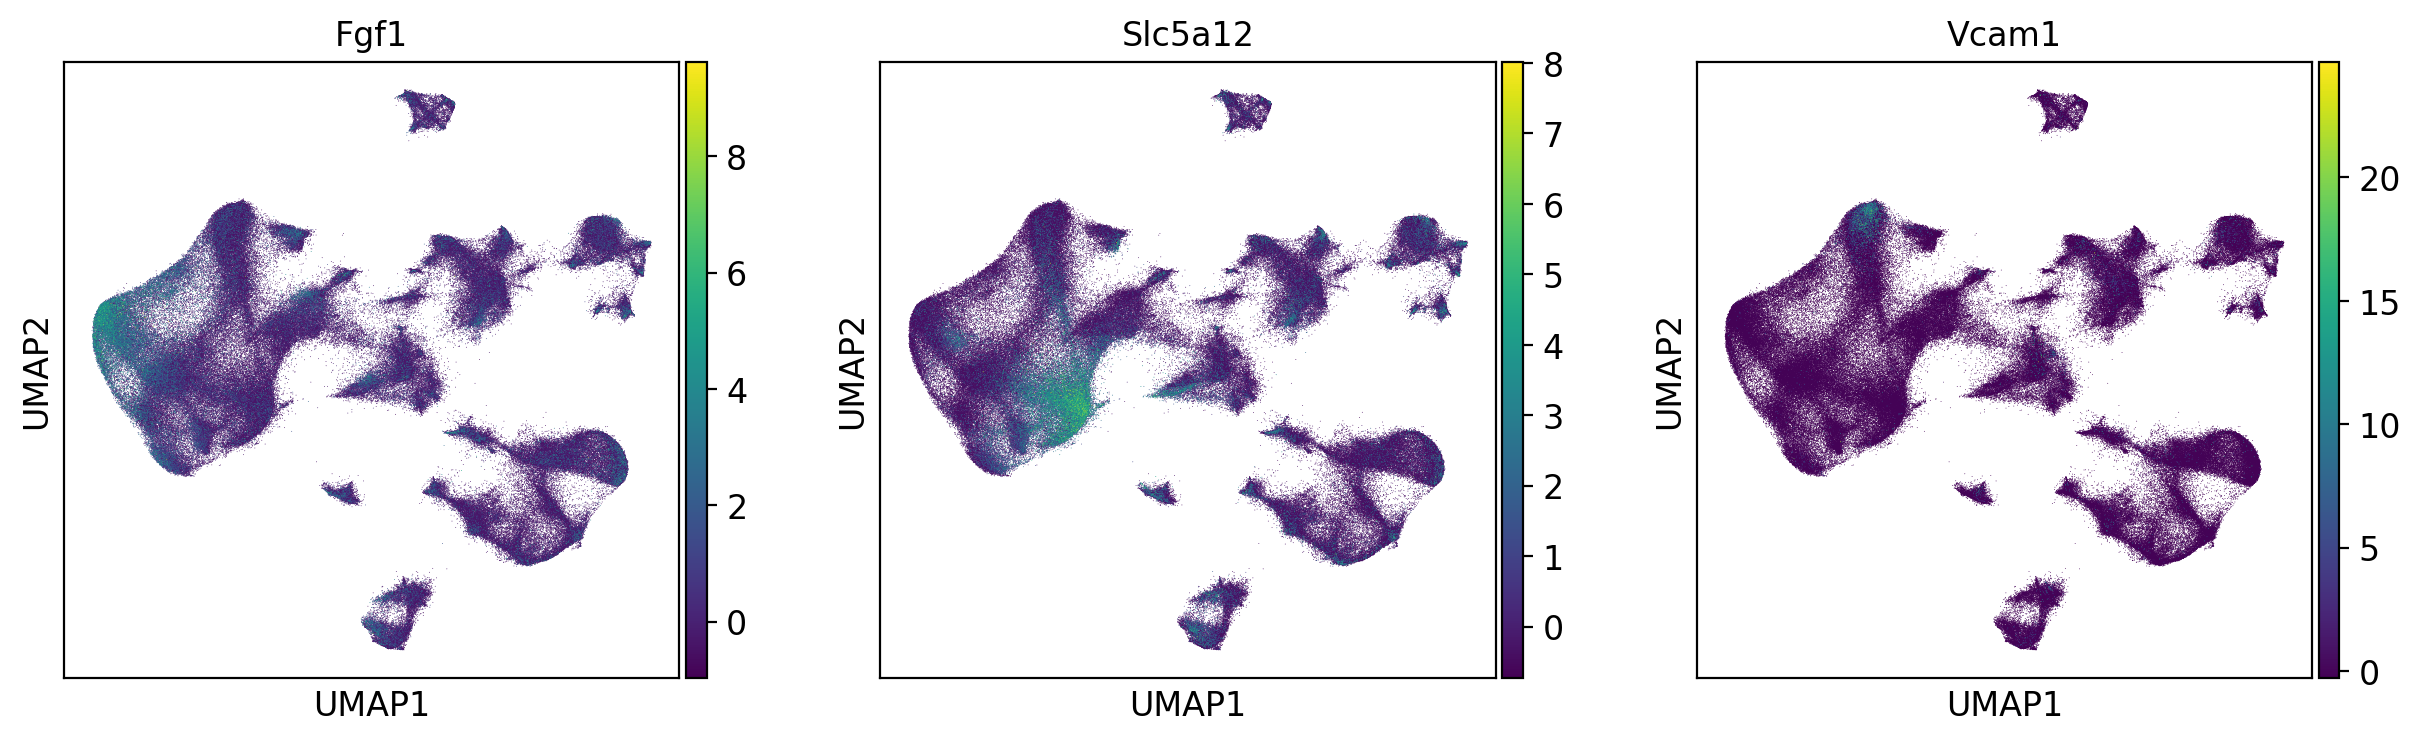

In [95]:
sc.settings.set_figure_params(dpi=100, facecolor='white',fontsize=12)
sc.pl.umap(adata, color=['Fgf1','Slc5a12','Vcam1'])
#check a few marker genes of interest

In [94]:
adata.write('save_file_name.h5ad', compression='gzip')